In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import random

In [33]:
import kagglehub

path = kagglehub.dataset_download("ichwanakmaluddin/augment-d2")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/augment-d2


In [34]:
base_path = "/kaggle/input/augment-d2/augmented_dataset_2"

# Dapatkan list folder kelas (0, 1, 2, dst)
class_folders = sorted(os.listdir(base_path))

# Hitung jumlah file per kelas
for class_label in class_folders:
    class_path = os.path.join(base_path, class_label)
    if os.path.isdir(class_path):
        count = len(os.listdir(class_path))
        print(f"Class {class_label}: {count} images")


Class 0: 5500 images
Class 1: 3150 images
Class 2: 6000 images
Class 3: 5500 images
Class 4: 4565 images


In [35]:
# from google.colab import files
base_dir = '/kaggle/input/augment-d2/augmented_dataset_2'

filepaths = []
labels = []

for label in os.listdir(base_dir):
    label_dir = os.path.join(base_dir, label)
    if os.path.isdir(label_dir):
        for fname in os.listdir(label_dir):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                filepaths.append(os.path.join(base_dir, label, fname))
                labels.append(int(label))

df = pd.DataFrame({
    'filepath': filepaths,
    'label': labels
})

In [87]:
from tensorflow.keras.utils import image_dataset_from_directory

BATCH_SIZE = 64
IMG_SIZE = (256, 256)
DATA_DIR = "/kaggle/input/augment-d2/augmented_dataset_2"
SEED = 123

# 1. Load semua data tanpa split
full_ds = image_dataset_from_directory(
    DATA_DIR,
    seed=SEED,
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# 2. Hitung total jumlah batch
dataset_size = full_ds.cardinality().numpy()
train_size = int(0.7 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

# 3. Split dengan take() dan skip()
train_ds = full_ds.take(train_size)
val_ds = full_ds.skip(train_size).take(val_size)
test_ds = full_ds.skip(train_size + val_size)

# 4. Ambil nama label
class_names = full_ds.class_names
print("Label:", class_names)


Found 24715 files belonging to 5 classes.
Label: ['0', '1', '2', '3', '4']


In [89]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [90]:
from tensorflow.keras.applications import DenseNet121, EfficientNetB0
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_effnet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, GlobalAveragePooling2D, Concatenate, Dense, Dropout, BatchNormalization

# Input layer (pakai ukuran standar pretrained)
input_layer = Input(shape=(256, 256, 3), name='input_image')

# Preprocessing untuk masing-masing backbone
densenet_input = Lambda(preprocess_densenet)(input_layer)
effnet_input = Lambda(preprocess_effnet)(input_layer)

# DenseNet121
densenet_base = DenseNet121(include_top=False, weights='imagenet', input_tensor=densenet_input)
for layer in densenet_base.layers[:60]:  # Freeze sebagian layer
    layer.trainable = False
densenet_out = GlobalAveragePooling2D()(densenet_base.output)

# EfficientNetB0
effnet_base = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=effnet_input)
for layer in effnet_base.layers[:60]:  # Freeze sebagian layer
    layer.trainable = False
effnet_out = GlobalAveragePooling2D()(effnet_base.output)

# Gabungkan fitur dari kedua backbone
merged = Concatenate()([densenet_out, effnet_out])

# Fully connected layers
x = Dense(256, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output layer
output = Dense(5, activation='softmax')(x) 

# Buat model
model = Model(inputs=input_layer, outputs=output)

# Tampilkan ringkasan model
model.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_20 (Lambda)        │ (None, 256, 256, 3)    │              0 │ input_image[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_10         │ (None, 262, 262, 3)    │              0 │ lambda_20[0][0]        │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,408 │ zero_padding2d_10[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_11         │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 64, 64, 64)     │              0 │ zero_padding2d_11[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 64, 64, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 64, 64, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)        

 Total params: 11,712,232 (44.68 MB)

 Trainable params: 11,125,577 (42.44 MB)

 Non-trainable params: 586,655 (2.24 MB)

In [92]:
from tensorflow.keras.optimizers import AdamW
model.compile(
    optimizer=AdamW(learning_rate=1e-5, weight_decay=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [93]:
from tensorflow.keras.callbacks import Callback

class EarlyStoppingByAccuracy(Callback):
    def __init__(self, monitor='val_accuracy', target=0.86):
        super(EarlyStoppingByAccuracy, self).__init__()
        self.monitor = monitor
        self.target = target

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is not None:
            if current >= self.target:
                print(f"\n[INFO] Reached {self.target*100:.2f}% {self.monitor}, stopping training.")
                self.model.stop_training = True


In [94]:
# Callbacks
checkpoint_cb = ModelCheckpoint(
    'best_model_densenet_effnet.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)


In [95]:
labels = df['label'].astype(int)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: 0.8987272727272727, 1: 1.5692063492063493, 2: 0.8238333333333333, 3: 0.8987272727272727, 4: 1.0828039430449068}


In [96]:
early_stop_acc = EarlyStoppingByAccuracy(monitor='val_accuracy', target=0.85)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint_cb, lr_scheduler, early_stop_acc]
)


Epoch 1/100
 89/270 ━━━━━━━━━━━━━━━━━━━━ 1:41 561ms/step - accuracy: 0.2836 - loss: 2.0662

Corrupt JPEG data: 35 extraneous bytes before marker 0xd9


270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.3667 - loss: 1.7870

Corrupt JPEG data: 35 extraneous bytes before marker 0xd9



Epoch 1: val_loss improved from inf to 0.84012, saving model to best_model_densenet_effnet.h5
270/270 ━━━━━━━━━━━━━━━━━━━━ 473s 844ms/step - accuracy: 0.3670 - loss: 1.7860 - val_accuracy: 0.6897 - val_loss: 0.8401 - learning_rate: 1.0000e-05
Epoch 2/100
 69/270 ━━━━━━━━━━━━━━━━━━━━ 1:59 596ms/step - accuracy: 0.6068 - loss: 1.0702

Corrupt JPEG data: 35 extraneous bytes before marker 0xd9


270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.6167 - loss: 1.0417

Corrupt JPEG data: 35 extraneous bytes before marker 0xd9



Epoch 2: val_loss improved from 0.84012 to 0.69151, saving model to best_model_densenet_effnet.h5
270/270 ━━━━━━━━━━━━━━━━━━━━ 218s 808ms/step - accuracy: 0.6168 - loss: 1.0415 - val_accuracy: 0.7484 - val_loss: 0.6915 - learning_rate: 1.0000e-05
Epoch 3/100
 61/270 ━━━━━━━━━━━━━━━━━━━━ 2:07 611ms/step - accuracy: 0.6881 - loss: 0.8421

Corrupt JPEG data: 35 extraneous bytes before marker 0xd9


270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.6887 - loss: 0.8337

Corrupt JPEG data: 35 extraneous bytes before marker 0xd9



Epoch 3: val_loss improved from 0.69151 to 0.61546, saving model to best_model_densenet_effnet.h5
270/270 ━━━━━━━━━━━━━━━━━━━━ 221s 819ms/step - accuracy: 0.6887 - loss: 0.8336 - val_accuracy: 0.7754 - val_loss: 0.6155 - learning_rate: 1.0000e-05
Epoch 4/100
 56/270 ━━━━━━━━━━━━━━━━━━━━ 2:10 612ms/step - accuracy: 0.7317 - loss: 0.7110

Corrupt JPEG data: 35 extraneous bytes before marker 0xd9


270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.7354 - loss: 0.7087

Corrupt JPEG data: 35 extraneous bytes before marker 0xd9



Epoch 4: val_loss improved from 0.61546 to 0.55905, saving model to best_model_densenet_effnet.h5
270/270 ━━━━━━━━━━━━━━━━━━━━ 219s 812ms/step - accuracy: 0.7354 - loss: 0.7086 - val_accuracy: 0.7953 - val_loss: 0.5591 - learning_rate: 1.0000e-05
Epoch 5/100
 67/270 ━━━━━━━━━━━━━━━━━━━━ 2:04 613ms/step - accuracy: 0.7633 - loss: 0.6404

Corrupt JPEG data: 35 extraneous bytes before marker 0xd9


270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.7620 - loss: 0.6347

Corrupt JPEG data: 35 extraneous bytes before marker 0xd9



Epoch 5: val_loss improved from 0.55905 to 0.51356, saving model to best_model_densenet_effnet.h5
270/270 ━━━━━━━━━━━━━━━━━━━━ 220s 815ms/step - accuracy: 0.7620 - loss: 0.6346 - val_accuracy: 0.8125 - val_loss: 0.5136 - learning_rate: 1.0000e-05
Epoch 6/100
 62/270 ━━━━━━━━━━━━━━━━━━━━ 2:07 611ms/step - accuracy: 0.8046 - loss: 0.5165

Corrupt JPEG data: 35 extraneous bytes before marker 0xd9


270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.7956 - loss: 0.5388

Corrupt JPEG data: 35 extraneous bytes before marker 0xd9



Epoch 6: val_loss improved from 0.51356 to 0.48341, saving model to best_model_densenet_effnet.h5
270/270 ━━━━━━━━━━━━━━━━━━━━ 219s 811ms/step - accuracy: 0.7956 - loss: 0.5388 - val_accuracy: 0.8263 - val_loss: 0.4834 - learning_rate: 1.0000e-05
Epoch 7/100
 69/270 ━━━━━━━━━━━━━━━━━━━━ 2:02 609ms/step - accuracy: 0.8152 - loss: 0.4743

Corrupt JPEG data: 35 extraneous bytes before marker 0xd9


270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.8141 - loss: 0.4886

Corrupt JPEG data: 35 extraneous bytes before marker 0xd9



Epoch 7: val_loss improved from 0.48341 to 0.46360, saving model to best_model_densenet_effnet.h5
270/270 ━━━━━━━━━━━━━━━━━━━━ 219s 810ms/step - accuracy: 0.8141 - loss: 0.4886 - val_accuracy: 0.8310 - val_loss: 0.4636 - learning_rate: 1.0000e-05
Epoch 8/100
 60/270 ━━━━━━━━━━━━━━━━━━━━ 2:08 613ms/step - accuracy: 0.8263 - loss: 0.4570

Corrupt JPEG data: 35 extraneous bytes before marker 0xd9


270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.8284 - loss: 0.4538

Corrupt JPEG data: 35 extraneous bytes before marker 0xd9



Epoch 8: val_loss improved from 0.46360 to 0.44179, saving model to best_model_densenet_effnet.h5
270/270 ━━━━━━━━━━━━━━━━━━━━ 229s 847ms/step - accuracy: 0.8284 - loss: 0.4538 - val_accuracy: 0.8438 - val_loss: 0.4418 - learning_rate: 1.0000e-05
Epoch 9/100
 60/270 ━━━━━━━━━━━━━━━━━━━━ 2:19 665ms/step - accuracy: 0.8440 - loss: 0.4290

Corrupt JPEG data: 35 extraneous bytes before marker 0xd9


270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.8421 - loss: 0.4235

Corrupt JPEG data: 35 extraneous bytes before marker 0xd9



Epoch 9: val_loss improved from 0.44179 to 0.43125, saving model to best_model_densenet_effnet.h5
270/270 ━━━━━━━━━━━━━━━━━━━━ 239s 884ms/step - accuracy: 0.8421 - loss: 0.4235 - val_accuracy: 0.8460 - val_loss: 0.4313 - learning_rate: 1.0000e-05
Epoch 10/100
 65/270 ━━━━━━━━━━━━━━━━━━━━ 2:21 690ms/step - accuracy: 0.8561 - loss: 0.3809

Corrupt JPEG data: 35 extraneous bytes before marker 0xd9


270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.8561 - loss: 0.3801

Corrupt JPEG data: 35 extraneous bytes before marker 0xd9



Epoch 10: val_loss improved from 0.43125 to 0.41506, saving model to best_model_densenet_effnet.h5
270/270 ━━━━━━━━━━━━━━━━━━━━ 239s 886ms/step - accuracy: 0.8561 - loss: 0.3800 - val_accuracy: 0.8573 - val_loss: 0.4151 - learning_rate: 1.0000e-05
Epoch 11/100
 60/270 ━━━━━━━━━━━━━━━━━━━━ 2:29 712ms/step - accuracy: 0.8668 - loss: 0.3610

Corrupt JPEG data: 35 extraneous bytes before marker 0xd9


270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.8683 - loss: 0.3493

Corrupt JPEG data: 35 extraneous bytes before marker 0xd9



Epoch 11: val_loss improved from 0.41506 to 0.39274, saving model to best_model_densenet_effnet.h5
270/270 ━━━━━━━━━━━━━━━━━━━━ 239s 884ms/step - accuracy: 0.8683 - loss: 0.3493 - val_accuracy: 0.8632 - val_loss: 0.3927 - learning_rate: 1.0000e-05
Epoch 12/100
 55/270 ━━━━━━━━━━━━━━━━━━━━ 2:15 628ms/step - accuracy: 0.8754 - loss: 0.3308

Corrupt JPEG data: 35 extraneous bytes before marker 0xd9


270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.8784 - loss: 0.3175

Corrupt JPEG data: 35 extraneous bytes before marker 0xd9



Epoch 12: val_loss did not improve from 0.39274
270/270 ━━━━━━━━━━━━━━━━━━━━ 221s 820ms/step - accuracy: 0.8784 - loss: 0.3175 - val_accuracy: 0.8610 - val_loss: 0.4063 - learning_rate: 1.0000e-05
Epoch 13/100
  5/270 ━━━━━━━━━━━━━━━━━━━━ 2:43 619ms/step - accuracy: 0.8866 - loss: 0.2860

KeyboardInterrupt: 

In [97]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


Corrupt JPEG data: 35 extraneous bytes before marker 0xd9


2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━

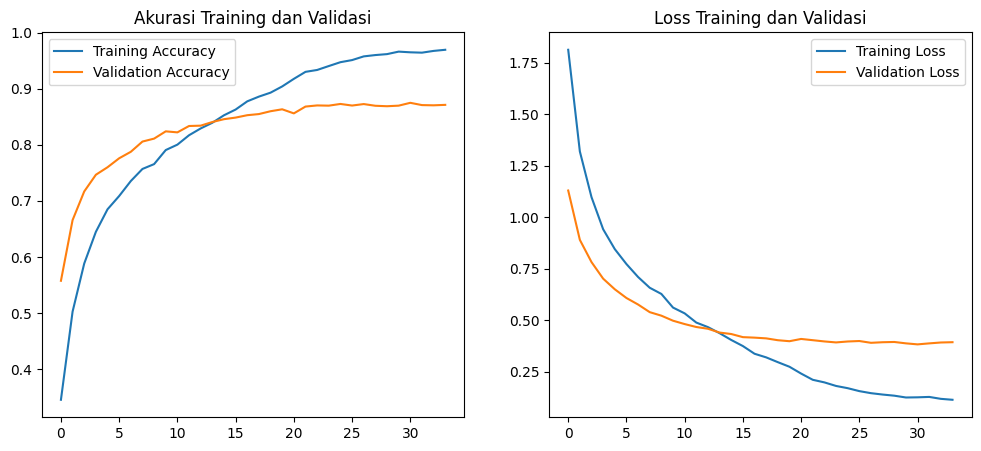

In [98]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import numpy as np


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Akurasi Training dan Validasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss Training dan Validasi')
plt.legend()

plt.show()



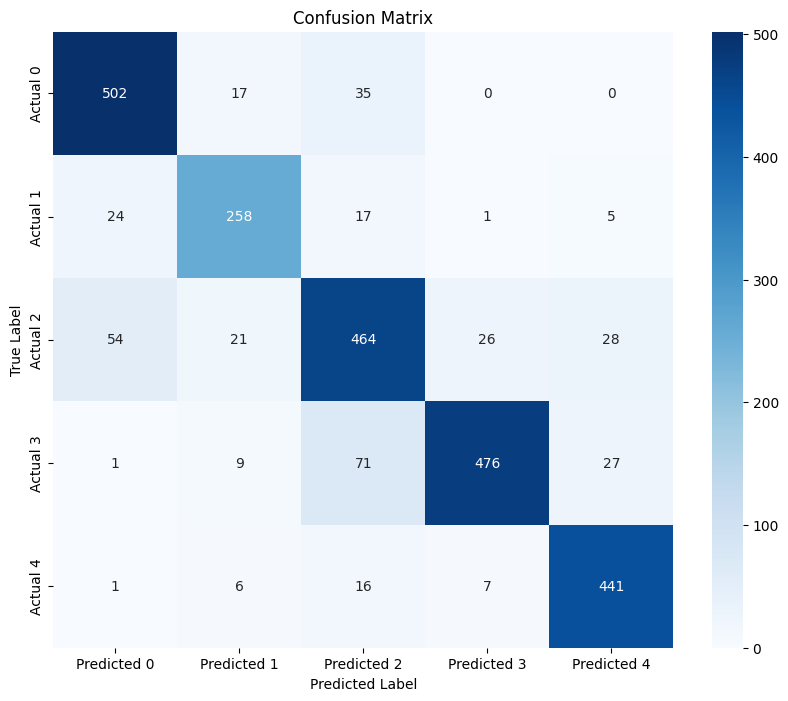

Classification Report:

              precision    recall  f1-score   support

           0     0.8625    0.9061    0.8838       554
           1     0.8296    0.8459    0.8377       305
           2     0.7695    0.7825    0.7759       593
           3     0.9333    0.8151    0.8702       584
           4     0.8802    0.9363    0.9074       471

    accuracy                         0.8540      2507
   macro avg     0.8550    0.8572    0.8550      2507
weighted avg     0.8563    0.8540    0.8539      2507



In [101]:
from sklearn.metrics import confusion_matrix


cm = pd.DataFrame(
    confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4]),
    index=[f"Actual {name}" for name in class_names],
    columns=[f"Predicted {name}" for name in class_names]
)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


ROC AUC EVALUATION ON TEST SET


Corrupt JPEG data: 35 extraneous bytes before marker 0xd9


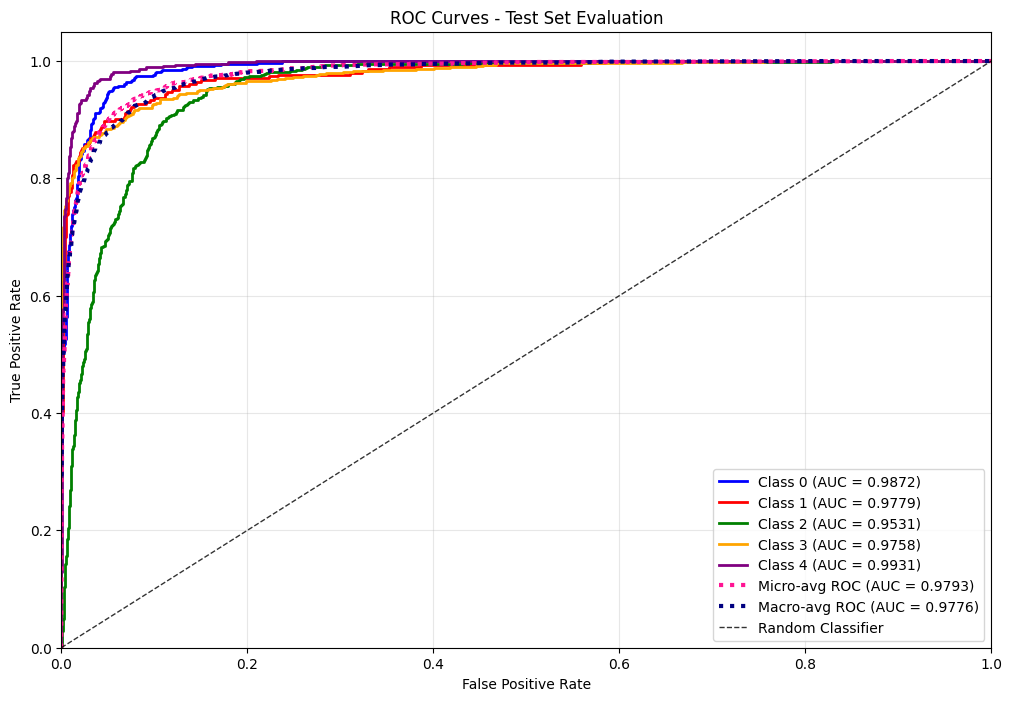


Micro-average AUC: 0.9793
Macro-average AUC: 0.9776

Per-class AUC scores:
  0: 0.9872
  1: 0.9779
  2: 0.9531
  3: 0.9758
  4: 0.9931

One-vs-Rest AUC: 0.9774
One-vs-One AUC: 0.9784


In [100]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# ROC AUC Evaluation on Test Set
print("="*60)
print("ROC AUC EVALUATION ON TEST SET")
print("="*60)

# Get prediction probabilities for test set
y_true_test = []
y_pred_proba_test = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true_test.extend(labels.numpy())
    y_pred_proba_test.extend(preds)

y_true_test = np.array(y_true_test)
y_pred_proba_test = np.array(y_pred_proba_test)

# Calculate ROC AUC for multiclass
n_classes = len(class_names)

# Binarize labels for multiclass ROC
y_true_bin = label_binarize(y_true_test, classes=range(n_classes))

# Calculate AUC for each class
roc_auc = {}
fpr = {}
tpr = {}

plt.figure(figsize=(12, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple']

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.4f})')

# Micro-average ROC curve
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_proba_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-avg ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=3)

# Macro-average ROC curve
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-avg ROC (AUC = {roc_auc["macro"]:.4f})',
         color='navy', linestyle=':', linewidth=3)

plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.8, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Test Set Evaluation')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Print summary
print(f"\nMicro-average AUC: {roc_auc['micro']:.4f}")
print(f"Macro-average AUC: {roc_auc['macro']:.4f}")
print("\nPer-class AUC scores:")
for i in range(n_classes):
    print(f"  {class_names[i]}: {roc_auc[i]:.4f}")

# Overall multiclass AUC scores
try:
    ovr_auc = roc_auc_score(y_true_test, y_pred_proba_test, multi_class='ovr', average='macro')
    ovo_auc = roc_auc_score(y_true_test, y_pred_proba_test, multi_class='ovo', average='macro')
    print(f"\nOne-vs-Rest AUC: {ovr_auc:.4f}")
    print(f"One-vs-One AUC: {ovo_auc:.4f}")
except Exception as e:
    print(f"Error calculating multiclass AUC: {e}")

In [102]:
from tensorflow.keras.preprocessing import image

# Path ke gambar yang ingin diuji
img_path = '/kaggle/input/augment-d2/augmented_dataset_2/2/007-0542-000.jpg'

# 1. Load gambar
img = image.load_img(img_path, target_size=(256, 256))  
# 2. Konversi ke array dan ekspansi dimensi (karena model expect batch)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Predicted class: 0


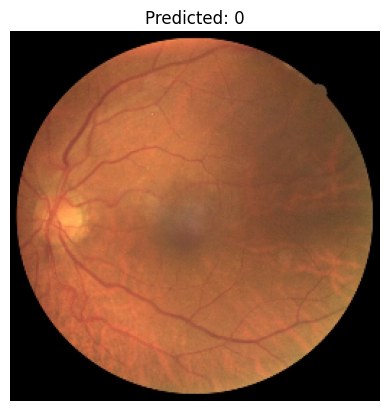

In [103]:
# Prediksi
pred = model.predict(img_array)
predicted_class = np.argmax(pred)

# Menampilkan hasil
print(f"Predicted class: {predicted_class}")

plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()



In [104]:
model.save('my_model_densenet_effnet.keras')